In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, PolynomialFeatures, OrdinalEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from pathlib import Path
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, IsolationForest
from sklearn.linear_model import LogisticRegression, ARDRegression, LinearRegression
from lightgbm import LGBMRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import tree
!pip install category_encoders
import category_encoders
from category_encoders.cat_boost import CatBoostEncoder
!pip install catboost
from catboost import CatBoostRegressor
!pip install lazypredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from sklearn.svm import SVC

In [ ]:
raw_train_data = pd.read_csv('/content/drive/MyDrive/shAI files/Diamond Competition/diamond_train.csv')
raw_test_data = pd.read_csv('/content/drive/MyDrive/shAI files/Diamond Competition/diamond_test.csv')

**Features Description:**

*   **price** price in US dollars (\$326--\$18,823)
*   **carat** is the diamond’s physical weight measured in metric carats. (0.2--5.01)
*   **cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal)
*   **color** diamond color, from J (worst) to D (best)
*   **clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1,    VS2, VS1, VVS2, VVS1, IF (best))
*   **x** length in mm (0--10.74)
*   **y** width in mm (0--58.9)
*   **z** depth in mm (0--31.8)
*   **depth** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
*   **table** width of the top of diamond relative to widest point (43--95)

# First Look at the data

In [ ]:
raw_train_data.head()

,Id,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,1.06,Ideal,I,SI2,61.80,57.00,4270,6.57,6.60,4.07
1,2,1.51,Premium,G,VVS2,60.90,58.00,15164,7.38,7.42,4.51
2,3,0.32,Ideal,F,VS2,61.30,56.00,828,4.43,4.41,2.71
3,4,0.53,Ideal,G,VS2,61.20,56.00,1577,5.19,5.22,3.19
4,5,0.70,Premium,H,VVS2,61.00,57.00,2596,5.76,5.72,3.50


In [ ]:
raw_test_data.head()

,Id,carat,cut,color,clarity,depth,table,x,y,z
0,1,0.34,Ideal,G,VVS2,61.10,57.00,4.52,4.48,2.75
1,2,0.71,Premium,E,VS2,62.70,58.00,5.74,5.68,3.58
2,3,0.44,Very Good,I,VS1,62.80,56.00,4.83,4.88,3.05
3,4,0.81,Premium,E,SI2,60.10,59.00,6.09,6.03,3.65
4,5,0.40,Ideal,G,VVS1,61.20,56.00,4.74,4.80,2.92


In [ ]:
processed_data = raw_train_data.drop(columns=['Id'])
cat_cols = processed_data.select_dtypes(include='object').columns.to_list()
num_cols = processed_data.select_dtypes(include=[np.number]).columns.to_list()

cut_cat = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_cat = ['J', 'I', 'H', 'G', 'F', 'E', 'D']
clarity_cat = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

colors=['#003f5c','#2f4b7c','#665191','#a05195','#d45087','#f95d6a','#ff7c43','#ffa600']

In [ ]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43152 entries, 0 to 43151
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    43152 non-null  float64
 1   cut      43152 non-null  object 
 2   color    43152 non-null  object 
 3   clarity  43152 non-null  object 
 4   depth    43152 non-null  float64
 5   table    43152 non-null  float64
 6   price    43152 non-null  int64  
 7   x        43152 non-null  float64
 8   y        43152 non-null  float64
 9   z        43152 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 3.3+ MB


In [ ]:
processed_data.describe()

,carat,depth,table,price,x,y,z
count,43152.00,43152.00,43152.00,43152.00,43152.00,43152.00,43152.00
mean,0.80,61.75,57.46,3929.49,5.73,5.74,3.54
std,0.47,1.44,2.23,3985.53,1.12,1.15,0.71
min,0.20,43.00,43.00,326.00,0.00,0.00,0.00
25%,0.40,61.00,56.00,947.75,4.71,4.72,2.91
50%,0.70,61.80,57.00,2401.00,5.70,5.71,3.53
75%,1.04,62.50,59.00,5312.00,6.54,6.54,4.04
max,5.01,79.00,95.00,18823.00,10.74,58.90,31.80


In [ ]:
raw_test_data.drop(columns=['Id']).describe()

,carat,depth,table,x,y,z
count,10788.00,10788.00,10788.00,10788.00,10788.00,10788.00
mean,0.80,61.76,57.45,5.73,5.73,3.54
std,0.48,1.42,2.24,1.12,1.12,0.70
min,0.20,54.00,50.00,0.00,0.00,0.00
25%,0.40,61.10,56.00,4.72,4.73,2.91
50%,0.70,61.80,57.00,5.70,5.71,3.52
75%,1.04,62.50,59.00,6.54,6.54,4.03
max,4.50,79.00,73.00,10.23,10.16,6.72


# EDA

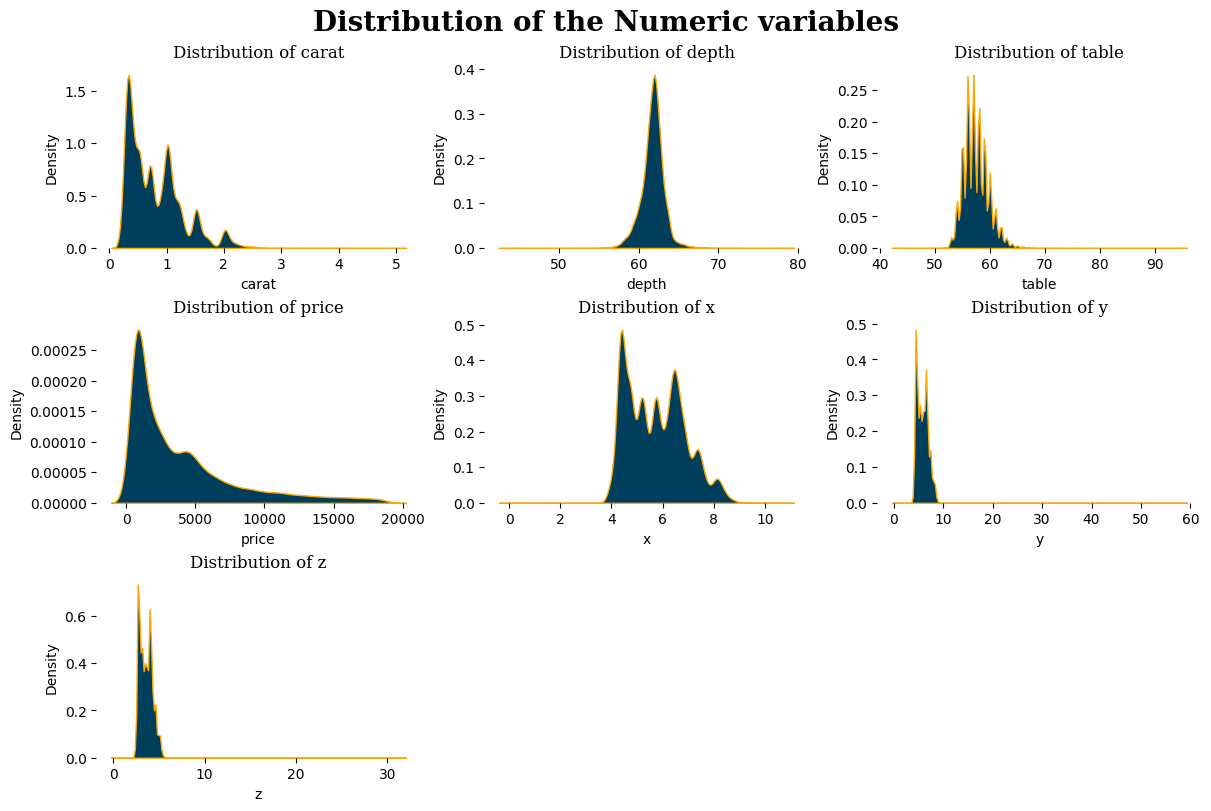

In [ ]:
j=0
fig = plt.figure(figsize=(12,8), constrained_layout=True)
plt.suptitle("Distribution of the Numeric variables", family='serif', size=20, weight='bold')
for i in num_cols:
    ax = plt.subplot(331+j)
    ax = sns.kdeplot(data=processed_data, x=i, color=colors[0], fill=True, edgecolor=colors[-1], alpha=1)
    ax.set_title("Distribution of {}".format(i), family='serif')
    for s in ['left','right','top','bottom']:
        ax.spines[s].set_visible(False)
    j=j+1

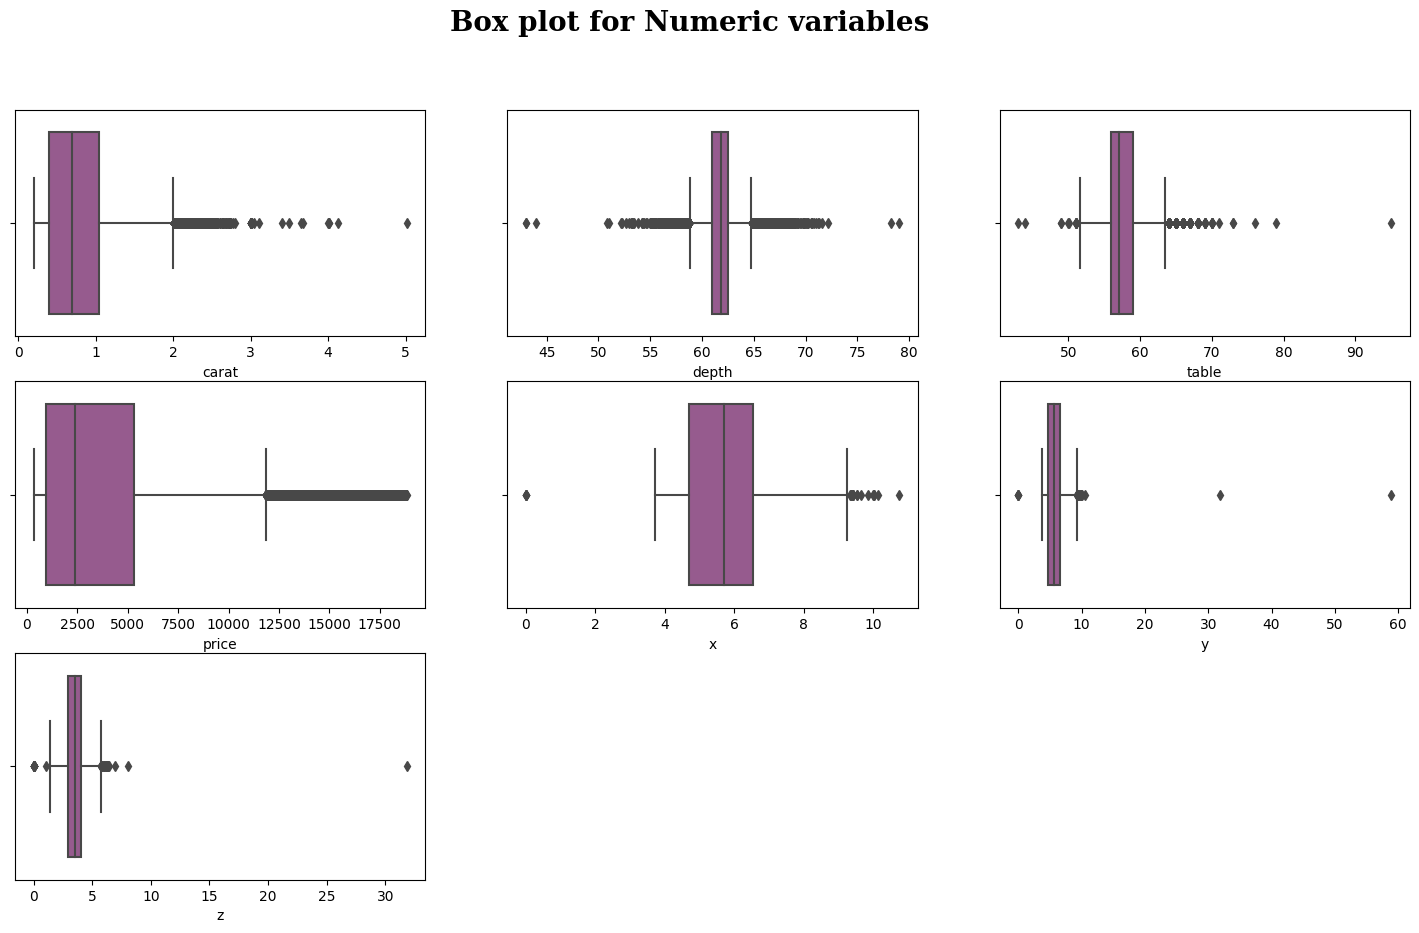

In [ ]:
fig = plt.figure(figsize=(18,10), )
j = 0
plt.suptitle("Box plot for Numeric variables", family='serif', size=20, weight='bold')
for i in num_cols:
    ax = plt.subplot(331+j)
    ax = sns.boxplot(data=processed_data, x=i, color=colors[3])
    j = j+1

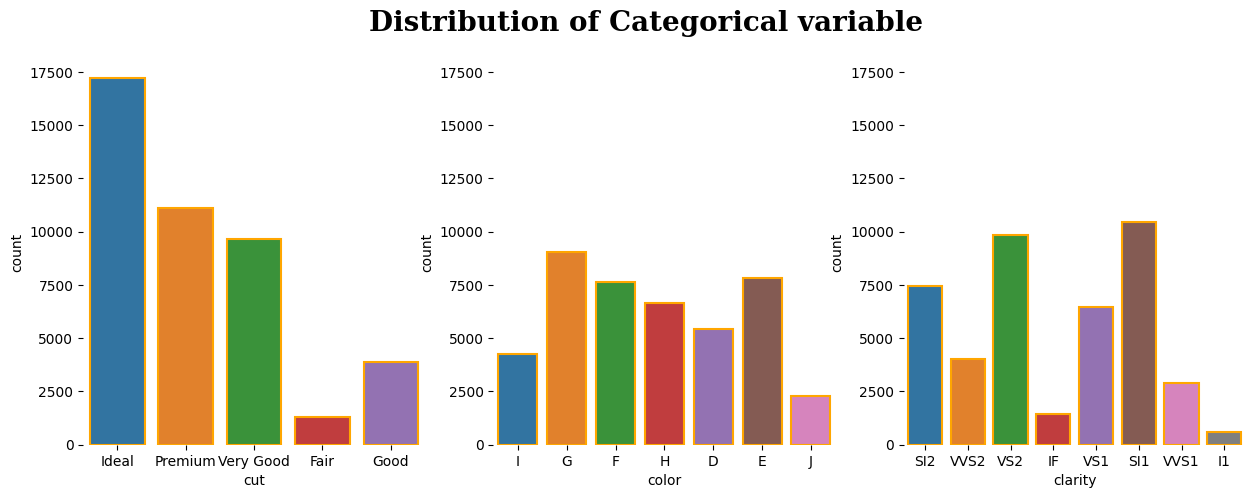

In [ ]:
fig=plt.figure(figsize=(15,5))
plt.suptitle("Distribution of Categorical variable", family='serif', size=20, weight='bold')
ax1=plt.subplot(131)
sns.countplot(data=processed_data, x=cat_cols[0], ax=ax1, linewidth=1.5, edgecolor=colors[-1])
ax2=plt.subplot(132, sharey=ax1)
sns.countplot(data=processed_data, x=cat_cols[1], ax=ax2,linewidth=1.5, edgecolor=colors[-1])   
ax3=plt.subplot(133, sharey=ax1)
sns.countplot(data=processed_data, x=cat_cols[2], ax=ax3,linewidth=1.5, edgecolor=colors[-1])
for s in ['left','right','top','bottom']:
  ax1.spines[s].set_visible(False)
  ax2.spines[s].set_visible(False)
  ax3.spines[s].set_visible(False)

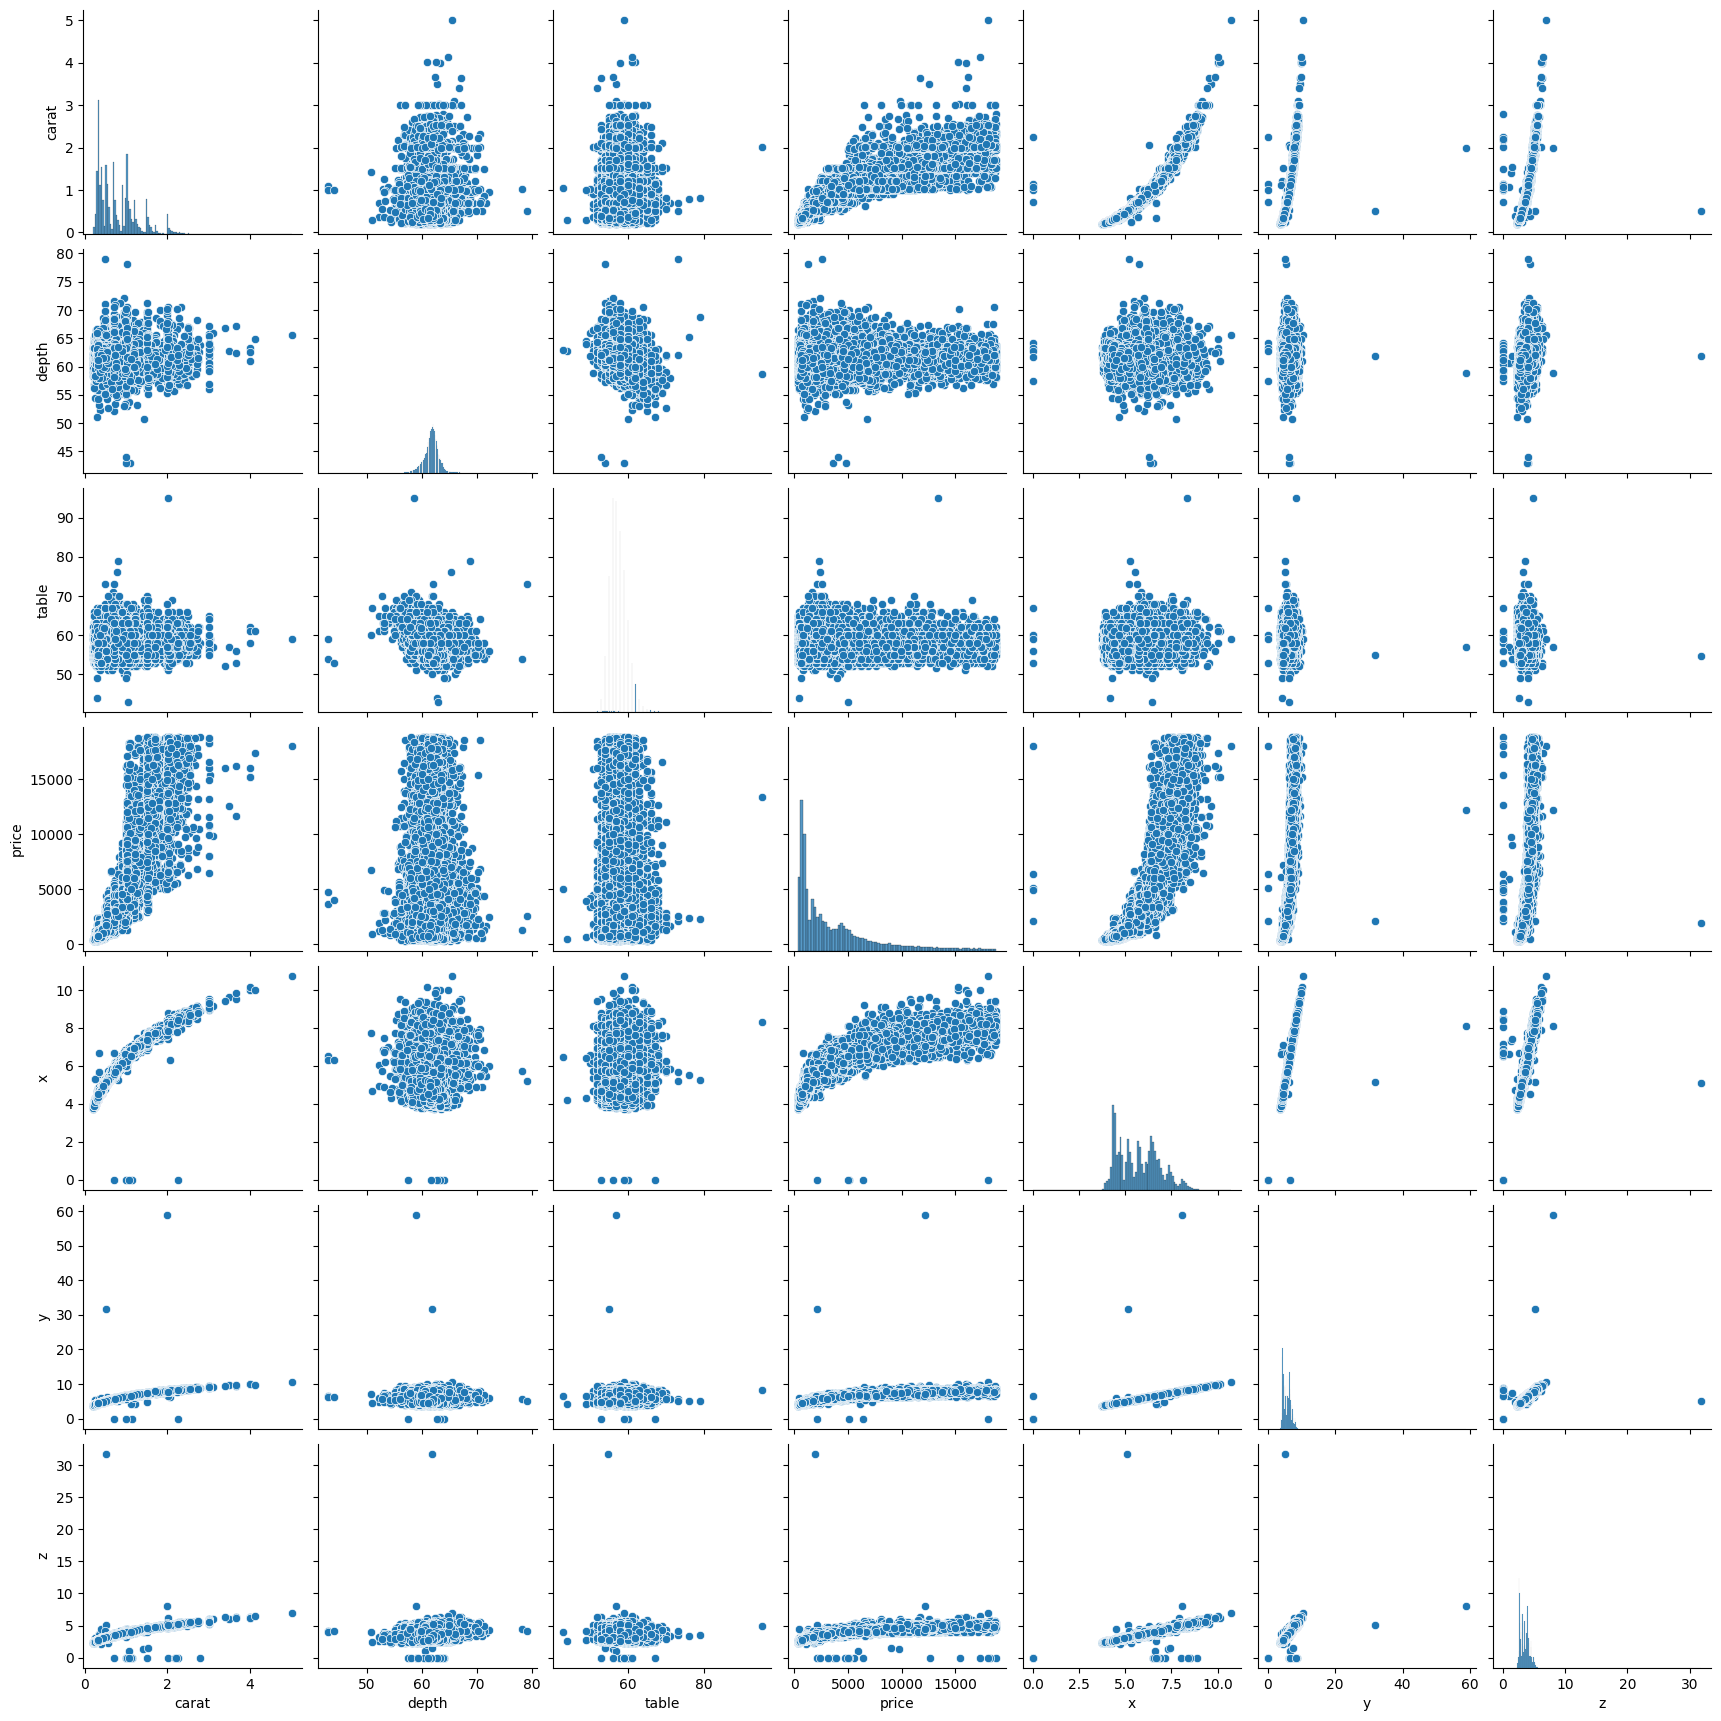

In [ ]:
sns.pairplot(processed_data)

In [ ]:
processed_data.skew()

carat    1.11
depth   -0.16
table    0.80
price    1.62
x        0.38
y        2.91
z        1.80
dtype: float64

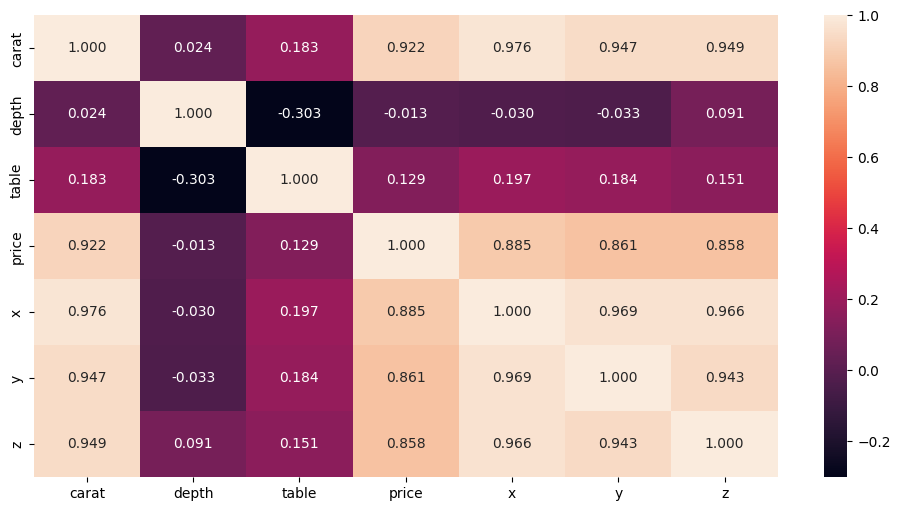

In [ ]:
corr = processed_data.corr("pearson")
# Method of correlation:
#    pearson : standard correlation coefficient
#    kendall : Kendall Tau correlation coefficient
#    spearman : Spearman rank correlation

plt.figure(figsize = (12,6))
sns.heatmap(corr, annot=True, fmt='.3f', cbar=True)
plt.show()

In [ ]:
# How each feature affects the price of diamonds.
corr["price"].sort_values(ascending=False)

price    1.00
carat    0.92
x        0.89
y        0.86
z        0.86
table    0.13
depth   -0.01
Name: price, dtype: float64

# Data Preprocessing

In [ ]:
processed_data = processed_data.drop(columns=['table'])
processed_data = processed_data[(processed_data['carat'] <= 4.5)]

**Checking for duplicate records in the data.**

In [ ]:
dups = processed_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
processed_data.drop_duplicates(inplace=True)
processed_data.shape

Number of duplicate rows = 189


(42962, 9)

**Checking Missing value.**

In [ ]:
processed_data.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
price      0
x          0
y          0
z          0
dtype: int64

Min value of "x", "y", "z" are zero this indicates that there are faulty values in data that represents dimensionless or 2-dimensional diamonds. So we need to filter out those as it clearly faulty data points.

In [ ]:
Target = processed_data['price']
Input_data = processed_data.drop(columns=['price'])
num_data = processed_data.select_dtypes(include=[np.number]).drop(columns=['price'])
cat_dat = processed_data.select_dtypes(include='object')

# Outliers Treatment

In [ ]:
# Outliers IsolationForest
# isolation_forest = IsolationForest(random_state=42)
# outlier_pred = isolation_forest.fit_predict(num_data)
# outlier_pred
# Input_data = Input_data.iloc[outlier_pred == 1]
# Target = Target.iloc[outlier_pred == 1]
# num_data = num_data.iloc[outlier_pred == 1]
# cat_dat = cat_dat.iloc[outlier_pred == 1]

In [ ]:
# remove_outlier:
def remove_outlier(feature):
    sorted(feature)
    Q1 , Q3 = np.percentile(feature, [25,75])
    IQR = Q3 - Q1
    lower_range= Q1 - (1.5 * IQR)
    upper_range= Q3 + (1.5 * IQR)
    return lower_range, upper_range

In [ ]:
def Outliers_handling(DataFrame):
  DataFrame['y'] = np.where(DataFrame['y'] > DataFrame['x'].max(), DataFrame['x'], DataFrame['y'])
  DataFrame['y'] = np.where(DataFrame['y'] == 0, DataFrame['y'].mean(), DataFrame['y'])
  DataFrame['x'] = np.where(DataFrame['x'] == 0, DataFrame['x'].mean(), DataFrame['x'])
  DataFrame['z'] = (DataFrame['x'] + DataFrame['y']) *  DataFrame['depth'] / 2 / 100
  return DataFrame

# Categorical Features Encoding

In [ ]:
# Incremental Encoding

def Incremental_Encoding(DataFrame):
  Increment_encoded_data = DataFrame.copy()
  Increment_encoded_data['cut'] = cat_dat['cut'].replace(cut_cat, [1, 2, 3, 4, 5])
  Increment_encoded_data['color'] = cat_dat['color'].replace(color_cat, [1, 2, 3, 4, 5, 6, 7])
  Increment_encoded_data['clarity'] = cat_dat['clarity'].replace(clarity_cat, [1, 2, 3, 4, 5, 6, 7, 8])
  return Increment_encoded_data

In [ ]:
# Label Encoding
def Label_Encoding(DataFrame):
  Label_encoded_data = DataFrame.copy()
  for feature in cat_cols:
    le = preprocessing.LabelEncoder()
    Label_encoded_data[feature] = le.fit_transform(Label_encoded_data[feature])
  return Label_encoded_data

In [ ]:
# One Hot Encoding

def One_Hot_Encoding(DataFrame):
  OH_encoded_data = DataFrame.copy()
  OH_encoded_data = pd.get_dummies(DataFrame, columns=cat_cols)
  return OH_encoded_data

In [ ]:
# Ordinal Encoding

def Ordinal_Encoding(DataFrame):
  ord_encoded_data = DataFrame.copy()
  for feature in cat_cols:
    ordinal_encoder = OrdinalEncoder()
    ord_encoded_data[feature] = ordinal_encoder.fit_transform(ord_encoded_data[[feature]])
  return ord_encoded_data

In [ ]:
# Target Encoding

def Target_Encoding(DataFrame, target):
  target_encoded_data = DataFrame.copy()
  for feature in cat_cols:
    Te_encoder = category_encoders.target_encoder.TargetEncoder()
    target_encoded_data[feature] = Te_encoder.fit_transform(target_encoded_data[feature], target)
  return target_encoded_data

In [ ]:
# Cat Boost Encoding

def CatBoost_Encoding(DataFrame):
  catB_encoded_data = DataFrame.copy()
  for feature in cat_cols:
    catB_encoder = CatBoostEncoder()
    catB_encoded_data[feature] = catB_encoder.fit_transform(catB_encoded_data[[feature]], Target)
  return catB_encoded_data

# Feature Scaling

In [ ]:
# Standard Scaler

def Standard_Scaler(DataFrame):
  standerd_scaled_data = DataFrame.copy()
  std_scaler = StandardScaler()
  standerd_scaled_data = pd.DataFrame(std_scaler.fit_transform(standerd_scaled_data), columns=standerd_scaled_data.columns, index=standerd_scaled_data.index)
  return standerd_scaled_data

In [ ]:
# MinMax Scaler

def MinMax_Scaler(DataFrame, mi, ma):
  min_max_scaled_data = DataFrame.copy()
  min_max_scaler = MinMaxScaler(feature_range=(mi, ma))
  min_max_scaled_data = pd.DataFrame(min_max_scaler.fit_transform(min_max_scaled_data), columns=min_max_scaled_data.columns, index=min_max_scaled_data.index)
  return min_max_scaled_data

In [ ]:
# Robust Scaler

def Robust_Scaler(DataFrame):
  robust_scaled_data = DataFrame.copy()
  robust_scaler = RobustScaler()
  robust_scaled_data = pd.DataFrame(robust_scaler.fit_transform(robust_scaled_data), columns=robust_scaled_data.columns)
  return robust_scaled_data

In [ ]:
# Polynomial Features

def Polynomial_Features(DataFrame, de):
  polynomial_features_data = DataFrame.copy()
  polynomial_features_scaler = PolynomialFeatures(degree=de, interaction_only=True)
  polynomial_features_data = pd.DataFrame(polynomial_features_scaler.fit_transform(polynomial_features_data), columns=polynomial_features_data.columns, index=polynomial_features_data.index)
  return polynomial_features_data

# Data Processing and Split

In [ ]:
encoded_data = Label_Encoding(cat_dat)
encoded_data = Standard_Scaler(encoded_data)
num_data = Outliers_handling(num_data)
scaled_data = Standard_Scaler(num_data)
gathered_data = pd.concat([scaled_data, encoded_data], axis=1)
gathered_data['price'] = Target
gathered_data.head()

,carat,depth,x,y,z,cut,color,clarity,price
0,0.55,0.04,0.75,0.78,0.77,-0.54,1.41,-0.48,4270
1,1.50,-0.59,1.47,1.52,1.40,0.43,0.24,1.84,15164
2,-1.01,-0.31,-1.17,-1.19,-1.20,-0.54,-0.35,0.68,828
3,-0.57,-0.38,-0.49,-0.46,-0.52,-0.54,0.24,0.68,1577
4,-0.21,-0.52,0.02,-0.01,-0.06,0.43,0.83,1.84,2596


In [ ]:
processed_data["carat_cat"] = pd.cut(processed_data["carat"], bins=[0.20, 0.40, 0.70, 1.04, 5.01], labels=[1, 2, 3, 4])
processed_data["carat_cat"] = processed_data["carat_cat"].fillna(3)

In [ ]:
R_set, S_set = train_test_split(gathered_data, test_size=0.2, random_state=42, shuffle=True, stratify=processed_data["carat_cat"]) #  , stratify=scaled_data["cut"]
X_train = R_set.drop(columns=['price'])
X_test = S_set.drop(columns=['price'])
y_train = R_set['price']
y_test = S_set['price']

# Base Model Building

In [ ]:
reg_models2 = [SVC, XGBRegressor, AdaBoostRegressor, LogisticRegression, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, 
               ARDRegression, LGBMRegressor, tree.DecisionTreeRegressor, KNeighborsRegressor, LinearRegression, GradientBoostingRegressor]
reg_models = [LGBMRegressor, XGBRegressor, CatBoostRegressor, LinearRegression, RandomForestRegressor]
reg = LazyRegressor(verbose=0, ignore_warnings=True, custom_metric=None, regressors=reg_models)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [ ]:
display(models)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
CatBoostRegressor,0.98,0.98,519.76,9.17
LGBMRegressor,0.98,0.98,533.02,0.41
XGBRegressor,0.98,0.98,539.09,2.57
RandomForestRegressor,0.98,0.98,546.86,16.97
LinearRegression,0.89,0.89,1331.96,0.07


# Model Training

In [ ]:
CAT = CatBoostRegressor()
CAT.fit(X_train, y_train)
CAT_y_predict = CAT.predict(X_test)
lin_rmse = mean_squared_error(y_test, CAT_y_predict, squared=False)

In [ ]:
lin_rmse

519.7592653323101

In [ ]:
CAT_features_importances = pd.Series(CAT.feature_importances_, index=X_train.columns)
CAT_features_importances.nlargest(39)

y         25.20
carat     23.39
clarity   19.58
x         10.70
z         10.53
color      9.45
cut        0.61
depth      0.54
dtype: float64

# Model Evaluation

In [ ]:
Id = raw_test_data['Id']
test_input_data = raw_test_data.drop(['Id'], axis=1)
test_input_data = test_input_data.drop(['table'], axis=1)
test_num_data = test_input_data.select_dtypes(include=[np.number])
test_cat_dat = test_input_data.select_dtypes(include='object')

In [ ]:
test_encoded_data = Label_Encoding(test_cat_dat)
test_encoded_data = Standard_Scaler(test_encoded_data)
test_num_data = Outliers_handling(test_num_data)
test_scaled_data = Standard_Scaler(test_num_data)
test_gathered_data = pd.concat([test_scaled_data, test_encoded_data], axis=1)

In [ ]:
y_predict = CAT.predict(test_gathered_data)
data = {'Id': Id, 'price':y_predict}
sub = pd.DataFrame(data=data)
sub.to_csv('test16.csv',index=False)